## Environment Setup

### Rewards Module

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from rewards import PersuasionRewards

rw_tokenizer = AutoTokenizer.from_pretrained('nasheed/rl-grp-prj-per-cls')

emo_model = AutoModelForSequenceClassification.from_pretrained('nasheed/rl-grp-prj-per-cls')
per_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

reward_module = PersuasionRewards(.1, .1, .55, .25, tokenizer=rw_tokenizer, emotion_cls=emo_model, persuasion_cls=per_model)

In [2]:
import torch

if torch.cuda.is_available(): reward_module.cuda()

### Human Proxy

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

checkpoint = "nasheed/rl-grp-prj-gpt2-baseagent"
hp_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
hp_tokenizer.padding_side = 'left'
human_proxy = AutoModelForCausalLM.from_pretrained(checkpoint).to(reward_module.device)

### Test Environment

In [4]:
from tqdm import tqdm
from typing import List
from convokit import Corpus
from itertools import count

from environment import PersuasionEnvironment


PURPOSE_TEXT = "Convince people to donate to charities."
corpus = Corpus(filename=r"..\data\persuasionforgood_corpus")

episode_avg_rewards: List[float] = []
episode_durations: List[int] = []
for conv in tqdm(corpus.iter_conversations(), desc="Establishing Gold Reward Dynamic", total=1017):
    env = PersuasionEnvironment(conv, human_proxy, hp_tokenizer, reward_module, PURPOSE_TEXT, render_mode='human')
    state, _ = env.reset()

    cumulative_reward = 0
    for step in count():
        _, reward, terminated, truncated, _ = env.step(sanity_test_mode=True)
        cumulative_reward += reward

        if terminated or truncated: break

    # Calculate per step avg
    avg_step_reward= cumulative_reward / (step+1)
    episode_avg_rewards.append(avg_step_reward)
    episode_durations.append(step+1)


Establishing Gold Reward Dynamic: 100%|██████████| 1017/1017 [05:34<00:00,  3.04it/s]


### Plot the Expert Rewards Dynamic

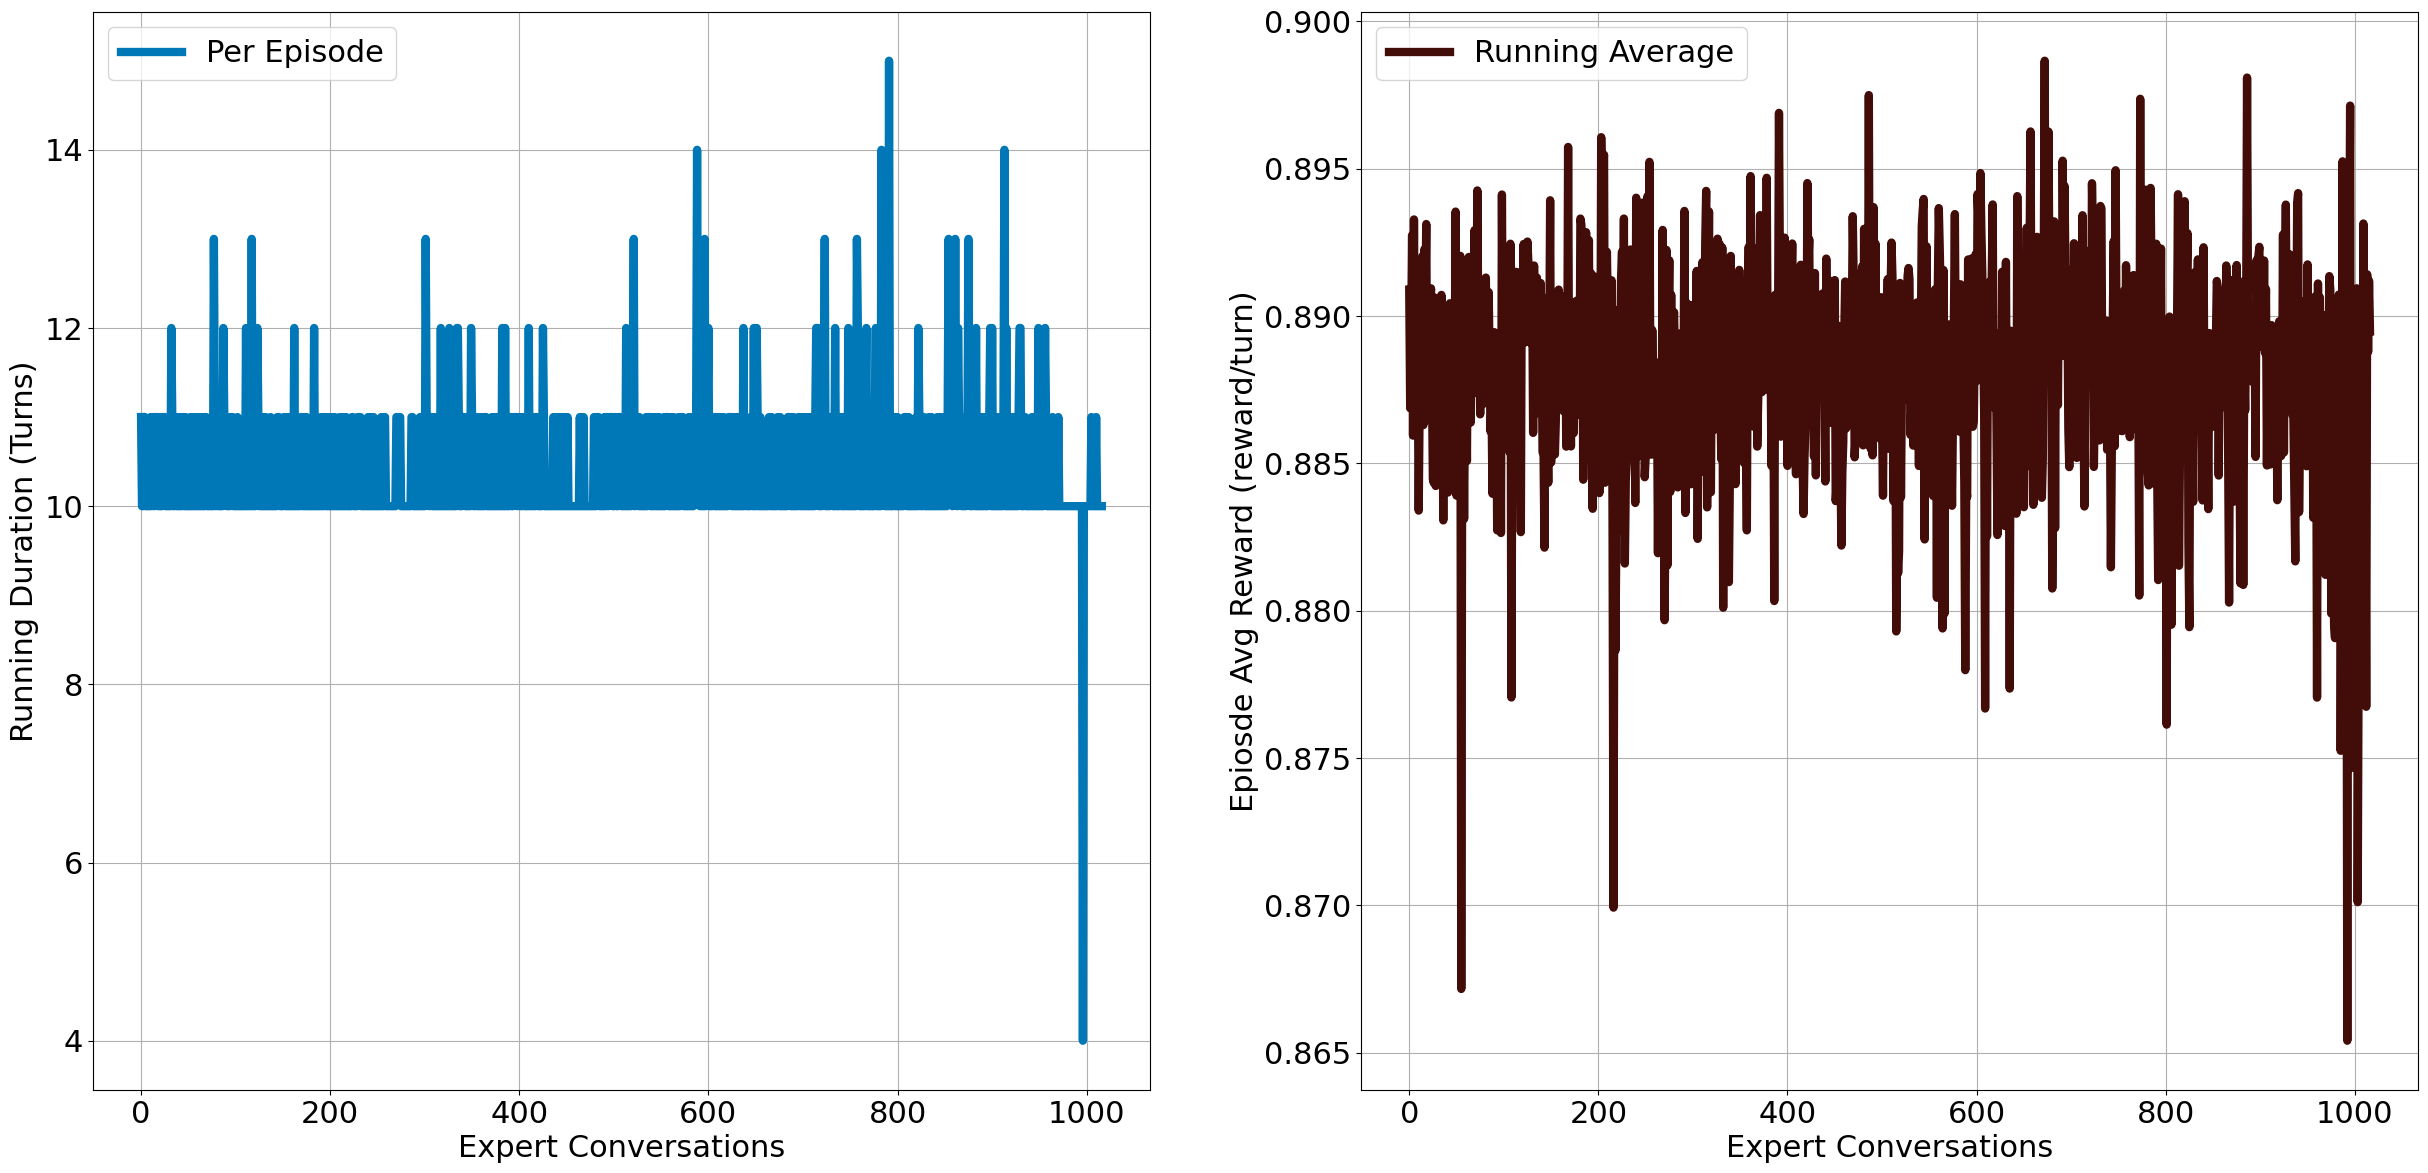

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,14)
plt.rcParams["font.size"] = 22

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('Expert Conversations')
ax1.set_ylabel('Running Duration (Turns)')
ax1.plot(episode_durations, linewidth=6, label='Per Episode', color='#0077b6')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Expert Conversations')
ax2.set_ylabel('Epiosde Avg Reward (reward/turn)')
ax2.plot(episode_avg_rewards, linewidth=6, label='Running Average', color='#420c09')
ax2.legend()
ax2.grid(True)

In [6]:
env.render(True)

 Convince people to donate to charities. <persuader>
 Hey, how are you doing, have you ever heard of a charity called Save the Children? <persuadee> No I havent. What is it about? <persuader>
 It's an international organization that promotes children's rights, provides relief and helps support children in developing countries, does that sound like something you'd get behind? <persuadee> No thank you. <persuader>
 May I ask why? Your help could really make a difference in a child's life, think of a child who didn't have enough to eat, just a small bit of help may have saved them, are you sure you're not interested? <persuadee> I am already making a difference in many children lives. <persuader>
 That's great, it sounds like it's an issue you really care about then, why not put some of that effort into a charity that's doing really great work like Save the Children? <persuadee> I have donated 15 years of my life to charity <persuader>
 I'm not asking you to donate years of your life, jus